In [103]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
from skimage.morphology import disk
from sklearn.cluster import KMeans

In [2]:
def plot_images(image_list, title_list, grid='off', file_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10))
    
    if len(image_list) == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)
    
    if file_name is not None:
        fig.savefig(results_directory + file_name)
        print('Image Plot Saved:', results_directory + file_name)

In [4]:
image_directory = 'images\\'

img1 = cv2.imread(image_directory + '1.png')
img2 = cv2.imread(image_directory + '2.png')
img3 = cv2.imread(image_directory + '3.png')
img4 = cv2.imread(image_directory + '4.png')
img5 = cv2.imread(image_directory + '5.png')
img6 = cv2.imread(image_directory + '6.png')
img7 = cv2.imread('..\\Missions\\mission_2_composite_3.tiff')

In [78]:
#select image
image_w_borders = img7
print('image_w_borders.shape:', image_w_borders.shape)

#resize so easier computation
image_w_borders = cv2.resize(image_w_borders, (0,0), fx=0.1, fy=0.1) 
h, w, c = image_w_borders.shape
print('image_w_borders.shape:', image_w_borders.shape)

#remove black edges
image_wo_borders = copy.deepcopy(image_w_borders)[10:h-10, 10:w-10, :].astype(np.uint8)
print('image_wo_borders.shape:', image_wo_borders.shape)

image_w_borders.shape: (5271, 5835, 3)
image_w_borders.shape: (527, 584, 3)
image_wo_borders.shape: (507, 564, 3)


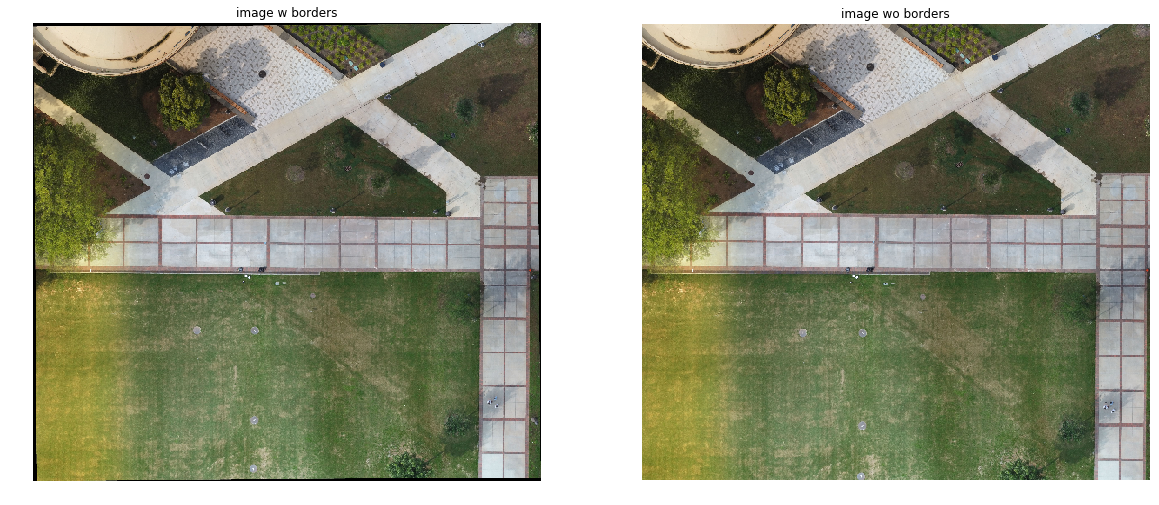

In [79]:
plot_images([image_w_borders, image_wo_borders], ['image w borders', 'image wo borders'])

In [141]:
original_img = copy.deepcopy(image_wo_borders)

NUM_CLUSTERS = 7

HEIGHT, WIDTH, CHANNELS = original_img.shape
print(HEIGHT, WIDTH, CHANNELS)

507 564 3


## Some kind of clustering - KMeans / CNN

In [142]:
from scipy import stats

def get_mode(img):
    unq, count = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
    return unq[count.argmax()]

def modeBlur(img, kernel_size):
    mode_img = np.zeros((img.shape))
    
    for i in range(0, int(img.shape[0]/kernel_size)):
        for j in range(0, int(img.shape[1]/kernel_size)):
            rows = slice(i*kernel_size, (i+1)*kernel_size)
            cols = slice(j*kernel_size, (j+1)*kernel_size)

            mode_img[rows, cols] = get_mode(img[rows, cols])
    
    return mode_img

In [143]:
def clustering(img):
    X = np.reshape(img, [-1, CHANNELS]).astype(np.float32)
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X)
    
    cluster_centers = kmeans.cluster_centers_.astype(int)
    
    clustered_img = np.reshape(cluster_centers[kmeans.labels_], (HEIGHT, WIDTH, CHANNELS)).astype(np.uint8)
    
    smooth_img = cv2.medianBlur(clustered_img, 5).astype(np.uint8)
    # smooth_img = modeBlur(clustered_img, 4).astype(np.uint8)

    return clustered_img, smooth_img, cluster_centers

## BGR - Clustered

In [144]:
clustered_img, smooth_img, clusters_bgr = clustering(original_img)

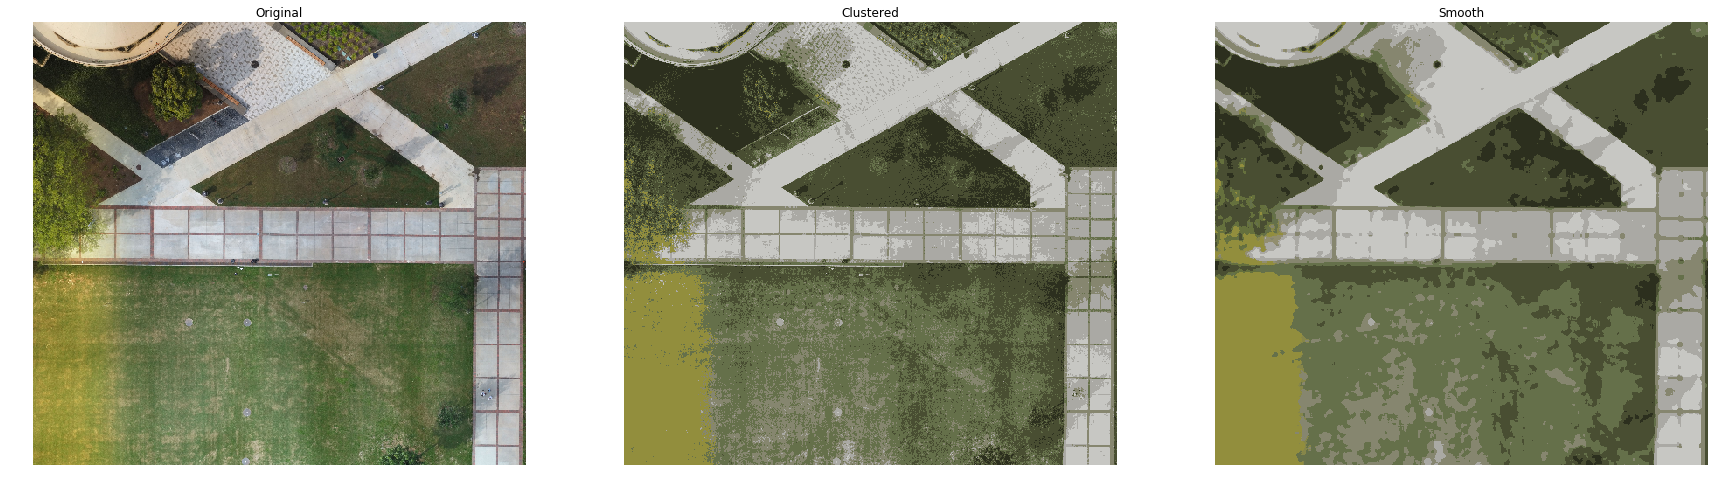

In [145]:
image_list = [original_img, clustered_img, smooth_img]
title_list = ['Original', 'Clustered', 'Smooth']
plot_images(image_list, title_list)

## HSV - Clustered

In [146]:
original_img_hsv = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

clustered_img_hsv, smooth_img_hsv, clusters_hsv = clustering(original_img_hsv)

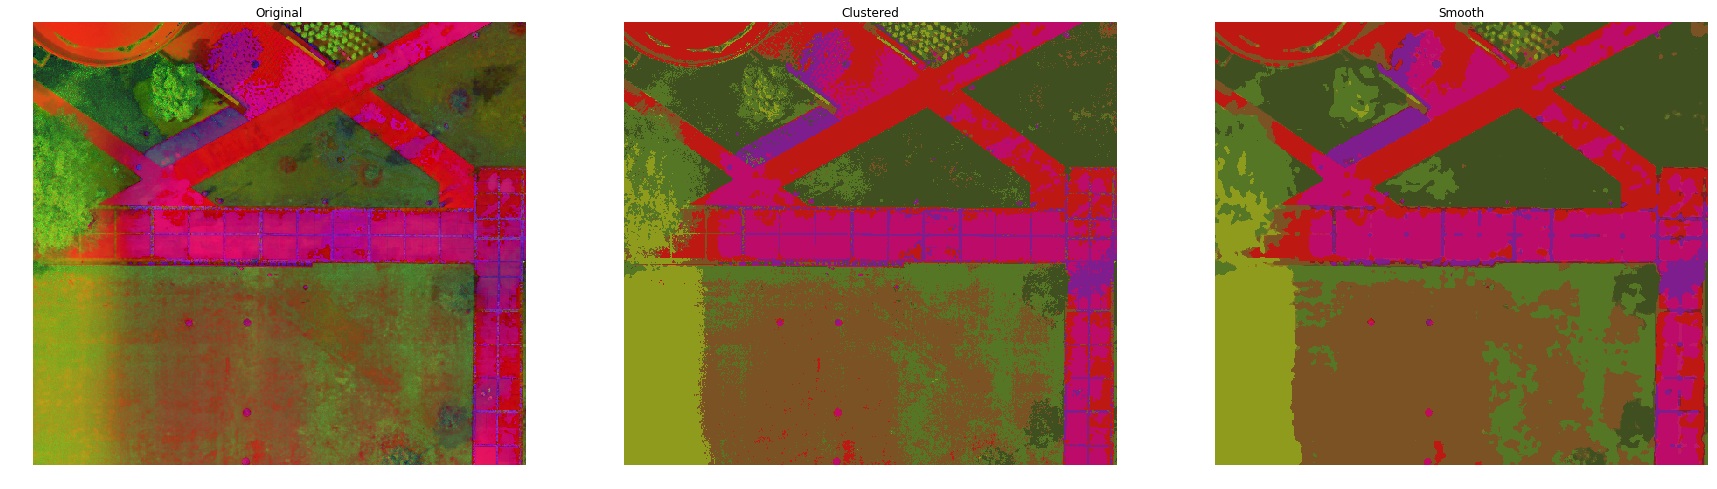

In [147]:
image_list = [original_img_hsv, clustered_img_hsv, smooth_img_hsv]
title_list = ['Original', 'Clustered', 'Smooth']
plot_images(image_list, title_list)

## BGR - Channels

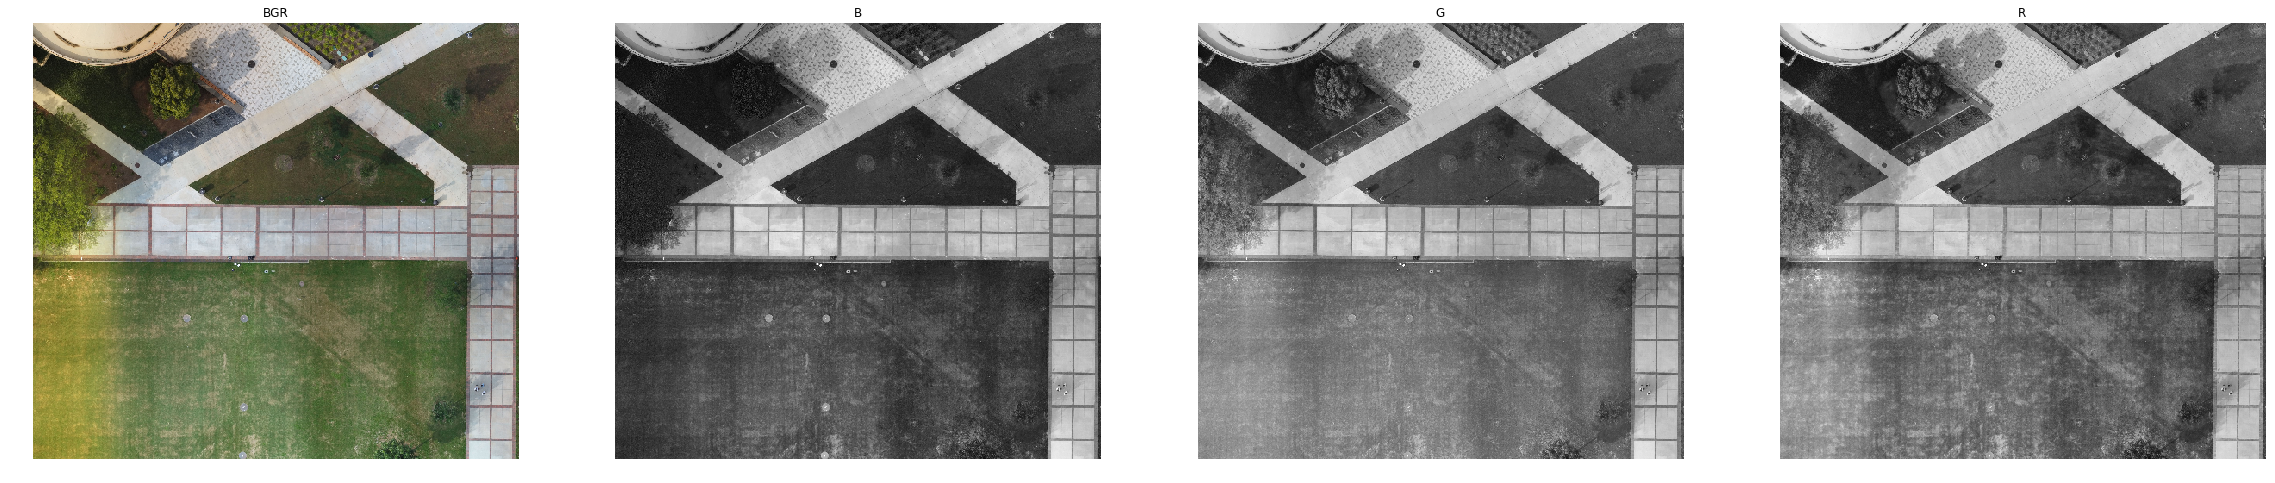

In [148]:
image_list = [original_img, original_img[:, :, 0], original_img[:, :, 1], original_img[:, :, 2]]
title_list = ['BGR', 'B', 'G', 'R']
plot_images(image_list, title_list)

## HSV - Channels

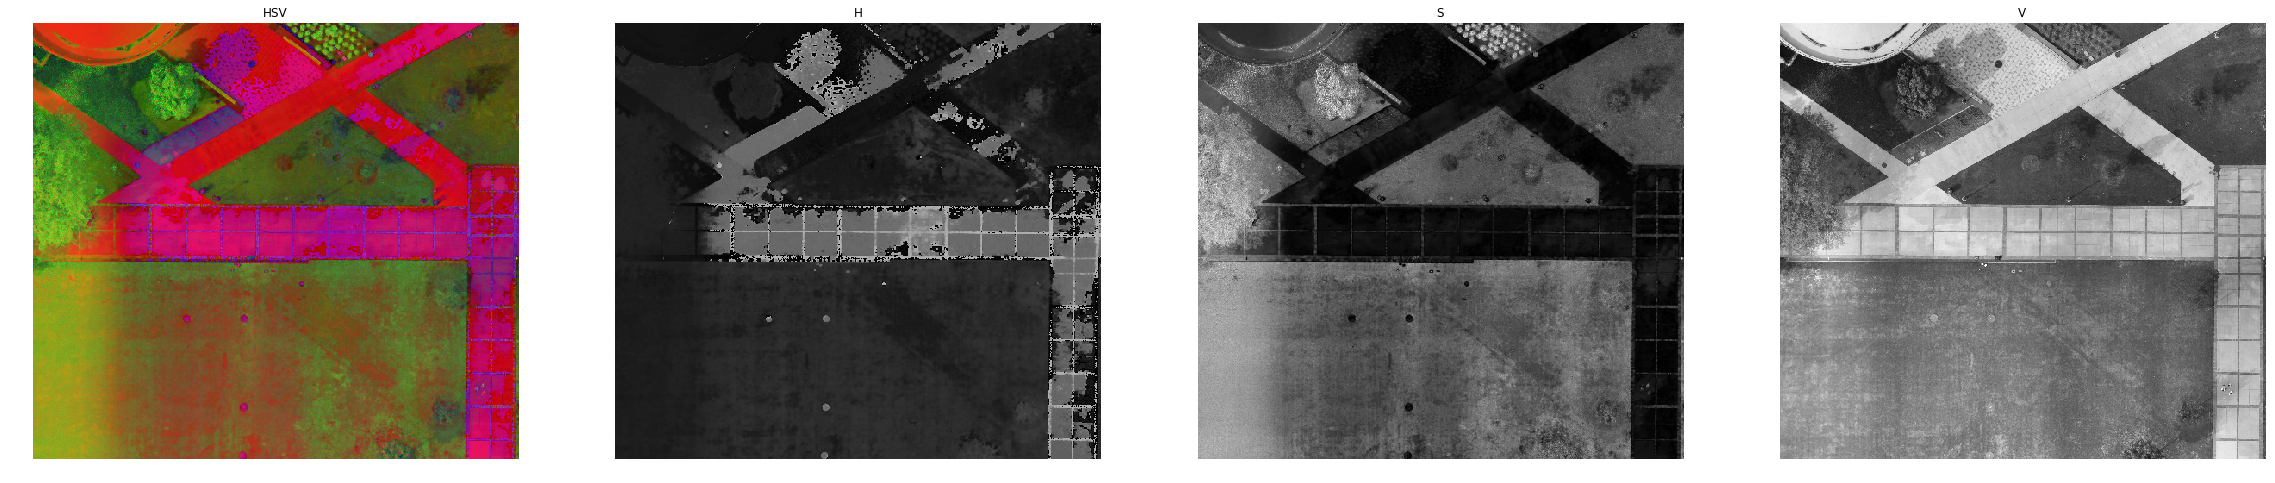

In [149]:
image_list = [original_img_hsv, original_img_hsv[:, :, 0], original_img_hsv[:, :, 1], original_img_hsv[:, :, 2]]
title_list = ['HSV', 'H', 'S', 'V']
plot_images(image_list, title_list)

In [116]:
# lower_blue_shadow = np.array([50, 50, 50]) #HSV
# upper_blue_shadow = np.array([175, 255, 255])
# mask = cv2.inRange(original_img_hsv, lower_blue_shadow, upper_blue_shadow)
# shadow_img = cv2.bitwise_and(mask, mask)

# lower_green_tree = np.array([25, 50, 50]) #HSV
# upper_green_tree = np.array([100, 255, 255])
# mask = cv2.inRange(original_img_hsv, lower_green_tree, upper_green_tree)
# tree_img = cv2.bitwise_and(mask, mask)

# image_list = [original_img_hsv, shadow_img, tree_img]
# title_list = ['HSV', 'Shadow', 'Tree']
# plot_images(image_list, title_list)

In [28]:
# s = cv2.calcHist(original_img_hsv[:, :, 1], [0], None, [256], [0, 256])
# plt.plot(s, 'b')


# mask = original_img_hsv[:, :, 1] > 150
# mask = mask.astype(np.uint8)*255

# image_list = [original_img_hsv[:, :, 1], mask]
# title_list = ['S', 'S mask']
# plot_images(image_list, title_list)

In [29]:
# edges = cv2.Canny(cv2.cvtColor(smooth_img, cv2.COLOR_BGR2GRAY), 100, 200)

# smooth_img_lines = copy.deepcopy(smooth_img)
# smooth_img_circles = copy.deepcopy(smooth_img)

# lines = cv2.HoughLines(edges, 1, np.pi/180, 80)
# if lines is not None:
#     print('Number of lines:', lines.shape[0])
#     for line in lines:
#         rho = line[0][0]
#         theta = line[0][1]
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a*rho
#         y0 = b*rho
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1011*(a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*(a))

#         cv2.line(smooth_img_lines, (x1,y1), (x2,y2), (0, 0, 255), 2)
    
# circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=100)
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     print('Number of circles:', circles.shape[1])

#     for circle in circles[0, :]:
#         center = (circle[0], circle[1])
#         cv2.circle(smooth_img_circles, center, 1, (255, 0, 255), 2)
#         radius = circle[2]
#         cv2.circle(smooth_img_circles, center, radius, (0, 255, 0), 1)

# image_list = [smooth_img, edges, smooth_img_lines, smooth_img_circles]
# title_list = ['Smooth', 'Edges', 'Lines', 'Circles']
# plot_images(image_list, title_list)

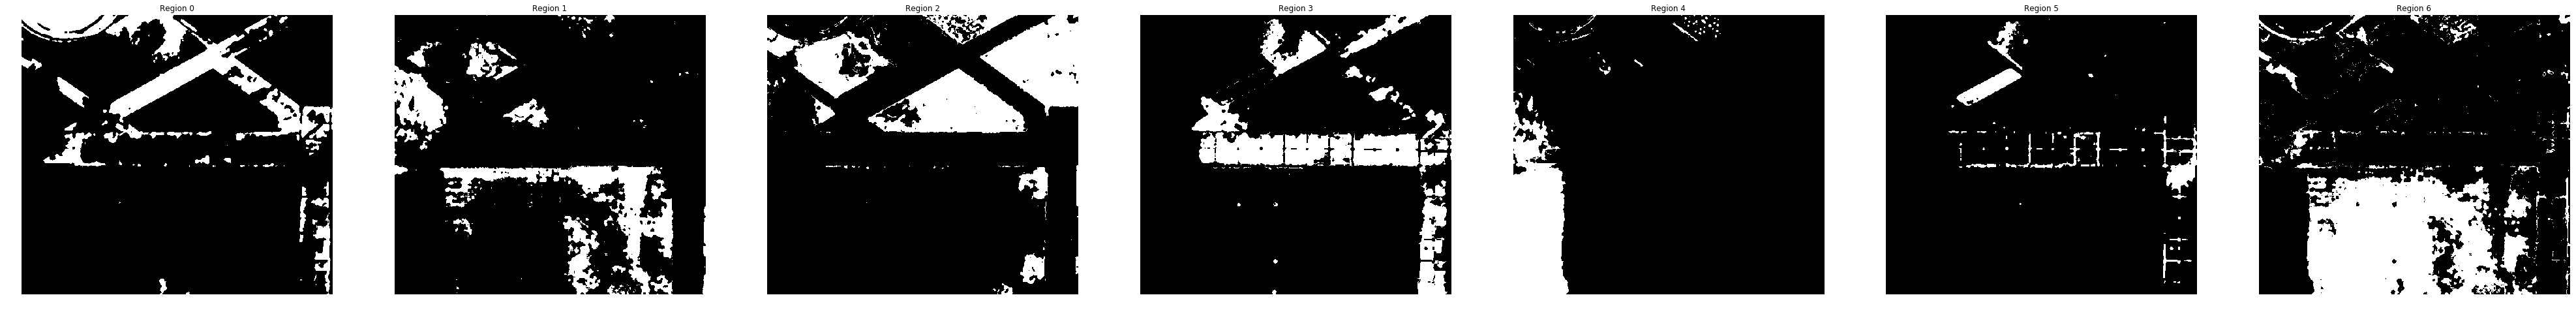

In [150]:
# break apart image into individual regions (there are NUM_CLUSTERS regions)

regions = []
for i in range(0, NUM_CLUSTERS):
    mask = smooth_img_hsv == clusters_hsv[i]
    mask = mask.astype(np.uint8)*255
    regions.append(mask[:, :, 0]) # 3 channels are just copies

# correct region is white
image_list = regions
title_list = ['Region '+str(i) for i in range(0, NUM_CLUSTERS)]
plot_images(image_list, title_list)

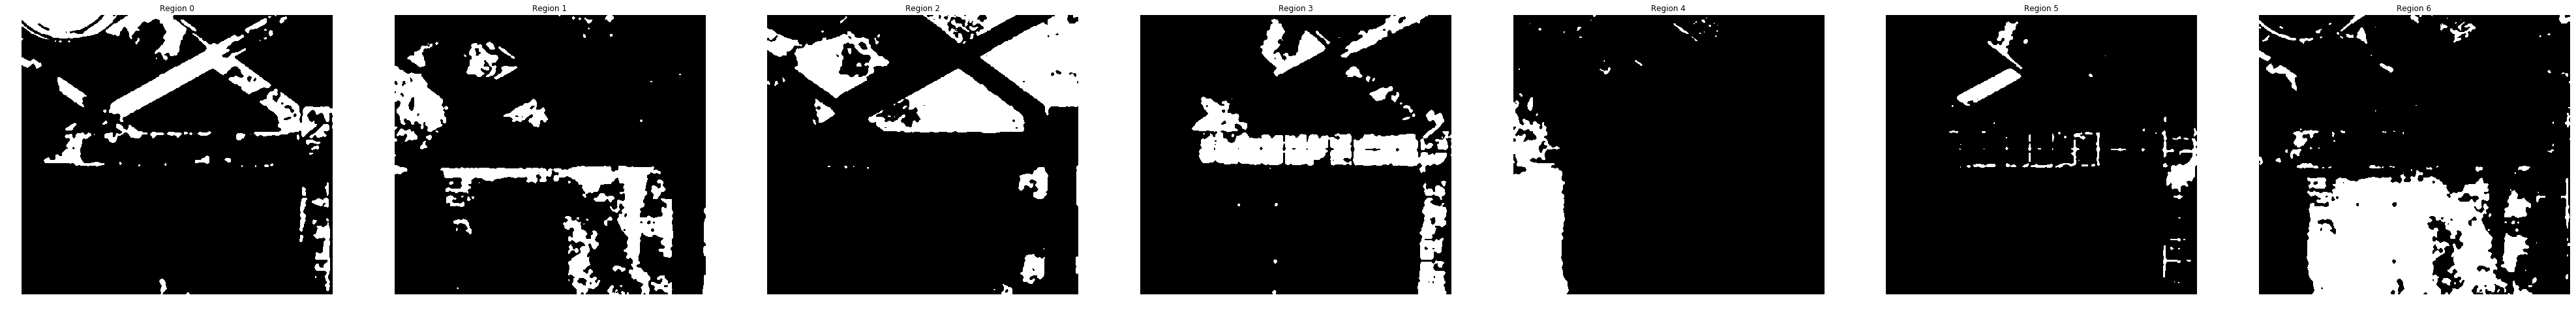

In [151]:
# apply mode filter to try and remove stray pixels

moded_regions = []
for i in range(0, NUM_CLUSTERS):
    moded_regions.append(np.array(Image.fromarray(regions[i]).filter(ImageFilter.ModeFilter(5))).astype(np.uint8))

# correct region is white
image_list = moded_regions
title_list = ['Region '+str(i) for i in range(0, NUM_CLUSTERS)]
plot_images(image_list, title_list)

In [152]:
# remove isolated black in all white region



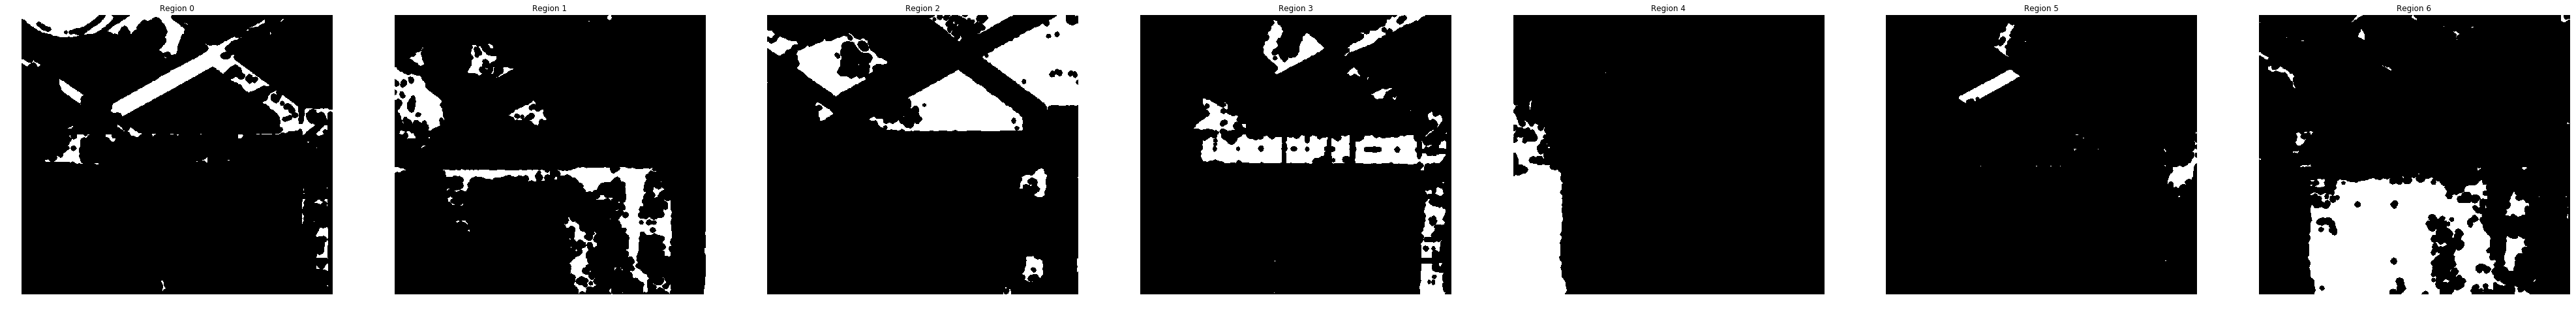

In [153]:
# smooth regions with disk

smooth_regions = []
for i in range(0, NUM_CLUSTERS):
    smooth_region = cv2.erode(moded_regions[i], disk(radius=3), iterations=1)
    smooth_regions.append(smooth_region)
    
# correct region is white
image_list = smooth_regions
title_list = ['Region '+str(i) for i in range(0, NUM_CLUSTERS)]
plot_images(image_list, title_list)

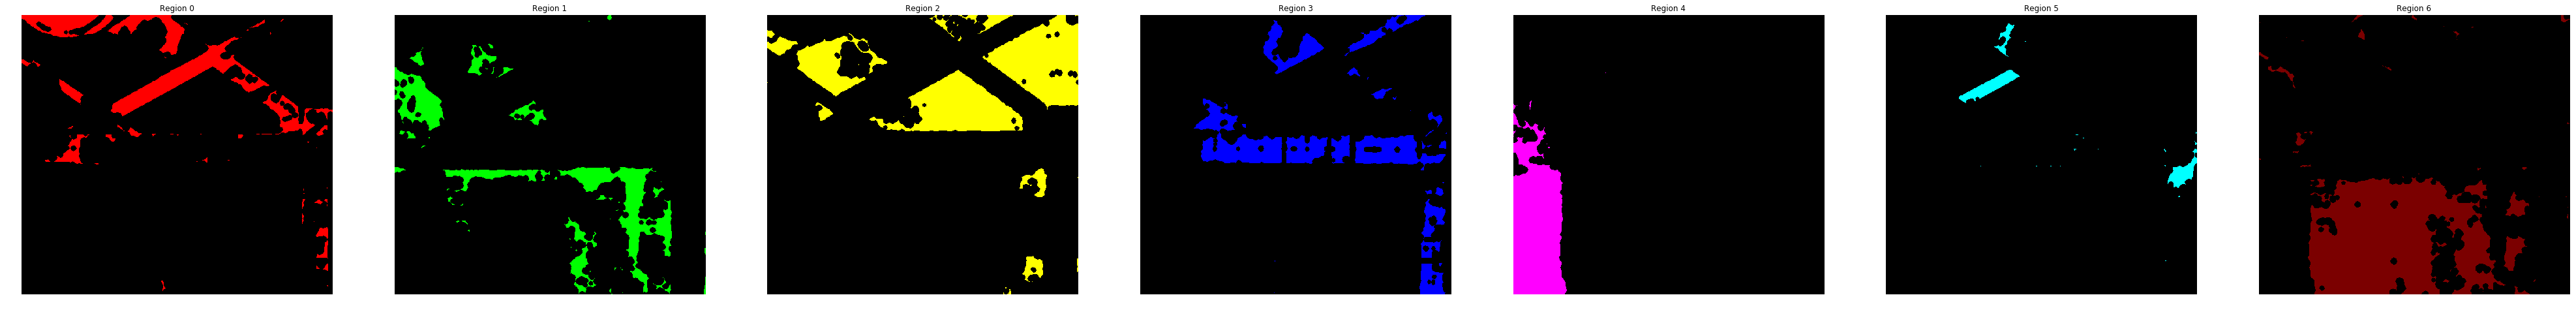

In [158]:
# now put together, since dilate was down and regions shrunk there should be "natural" borders between the regions

colored_regions = []
for i in range(0, NUM_CLUSTERS):
    
    mask = smooth_regions[i] == 255
    colored_region = np.zeros((HEIGHT, WIDTH, 3))
    
    # assign color
    if i == 0:
        color = [0, 0, 255]
    elif i == 1:
        color = [0, 255, 0]
    elif i == 2:
        color = [0, 255, 255]
    elif i == 3:
        color = [255, 0, 0]
    elif i == 4:
        color = [255, 0, 255]
    elif i == 5:
        color = [255, 255, 0]
    elif i == 6:
        color = [0, 0, 123]
    elif i == 7:
        color = [0, 123, 0]
    elif i == 8:
        color = [123, 0, 0]
    
    for j in range(0, 3):
        colored_region[mask, j] = color[j]
    
    colored_regions.append(colored_region.astype(np.uint8))

image_list = colored_regions
title_list = ['Region '+str(i) for i in range(0, NUM_CLUSTERS)]
plot_images(image_list, title_list)

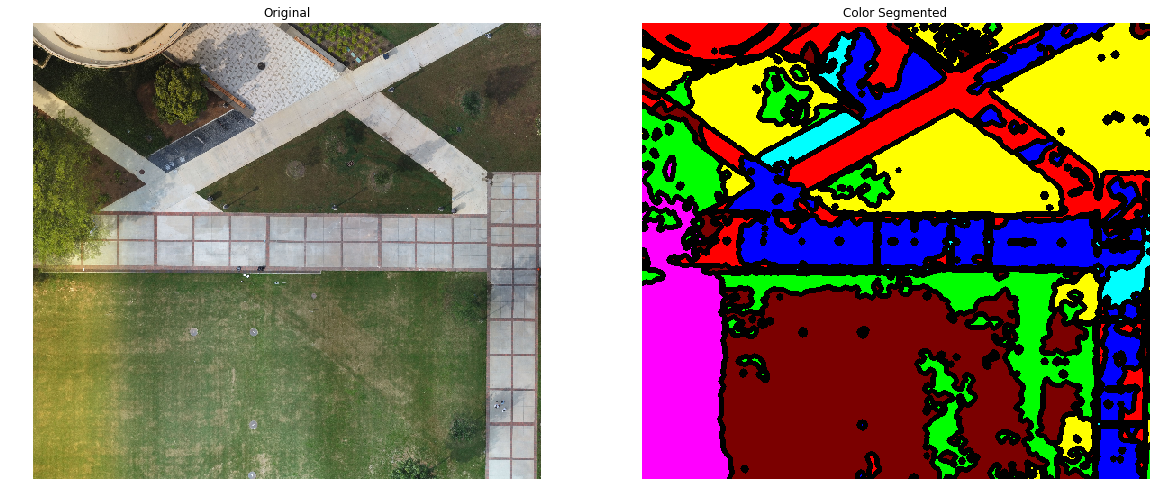

In [159]:
# stack all colors together and compare to original image to visualize regions

full_stack = np.zeros((HEIGHT, WIDTH, 3))

for i in range(0, NUM_CLUSTERS):
    mask = colored_regions[i] != 0 # != 0 means its color
    full_stack[mask] = colored_regions[i][mask]

full_stack = full_stack.astype(np.uint8)

image_list = [original_img, full_stack]
title_list = ['Original', 'Color Segmented']
plot_images(image_list, title_list)

match: [1, 2, 4, 6]
match: [0, 3, 5]


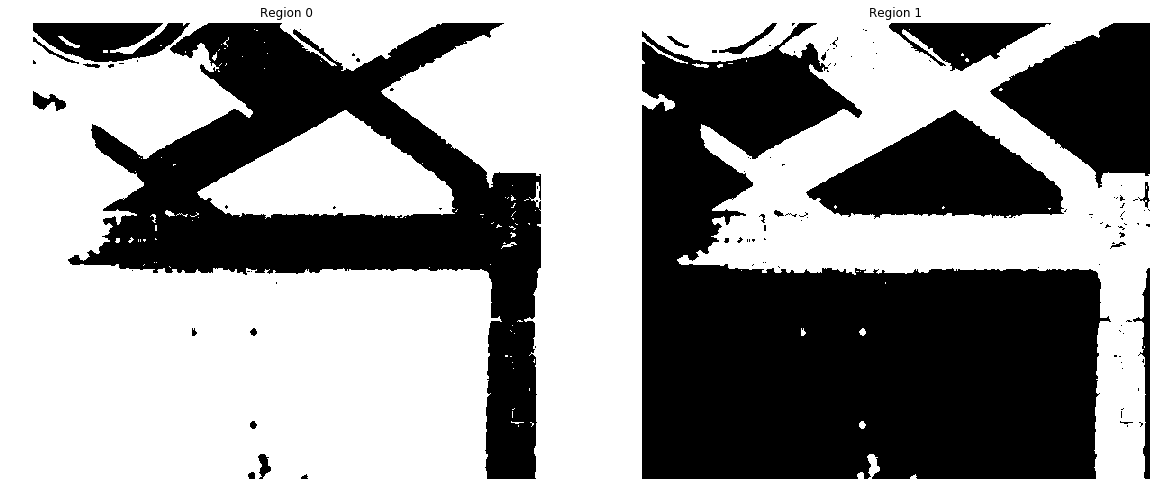

In [160]:
# match similar regions
matched = [[1, 2, 4, 6], [0, 3, 5]]

matched_regions = []
for match in matched:
    print('match:', match)
    matched = np.zeros((HEIGHT, WIDTH)).astype(np.uint8)
    for region_number in match:
        matched = cv2.bitwise_or(matched, regions[region_number])
    
    matched_regions.append(matched.astype(np.uint8))
    
image_list = matched_regions
title_list = ['Region '+str(i) for i in range(0, len(matched))]
plot_images(image_list, title_list)